In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, ReLU, Add, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Basic Identity Block (ResNet Block without downsampling)
def identity_block(x, filters):
    shortcut = x
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x

# Convolutional Block (used for downsampling and adjusting dimensions)
def conv_block(x, filters, stride=2):
    shortcut = x
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=stride)(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x

# Build Custom ResNet50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Conv2_x
    x = conv_block(x, [64, 64, 256], stride=1)
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    # Conv3_x
    x = conv_block(x, [128, 128, 512])
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    # Conv4_x
    x = conv_block(x, [256, 256, 1024])
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    # Conv5_x
    x = conv_block(x, [512, 512, 2048])
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

2025-05-25 08:14:42.736910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748160882.959186      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748160883.020571      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Directory Setup ---
base_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# --- Parameters ---
img_size = (224, 224)
batch_size = 16
num_classes = 4

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    channel_shift_range=20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [3]:
# Build and compile model
model = build_resnet50(input_shape=(*img_size, 3), num_classes=num_classes)

# --- Compile with SGD ---
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- EarlyStopping Callback ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Compute class weights
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# Add to training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

I0000 00:00:1748160896.730357      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748160925.005722     117 service.cc:148] XLA service 0x7d3d08002a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748160925.006658     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748160927.192777     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/63 ━━━━━━━━━━━━━━━━━━━━ 42:33 41s/step - accuracy: 0.3750 - loss: 1.8095

I0000 00:00:1748160940.362495     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 614ms/step - accuracy: 0.2699 - loss: 1.7249 - val_accuracy: 0.3611 - val_loss: 1.7337
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.2613 - loss: 1.7664 - val_accuracy: 0.3056 - val_loss: 1.5807
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.3057 - loss: 1.7339 - val_accuracy: 0.4167 - val_loss: 1.4880
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.2725 - loss: 1.7852 - val_accuracy: 0.2778 - val_loss: 2.2771
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.2494 - loss: 1.8324 - val_accuracy: 0.3333 - val_loss: 1.3679
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.2877 - loss: 1.7607 - val_accuracy: 0.3333 - val_loss: 1.4401
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.2970 - loss: 1.5355 - val_accuracy: 0.1944 - val_loss: 1.6164
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.2850 - loss: 1.5924 - val_accuracy: 0.361

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4137 - loss: 1.4036 

Test Accuracy: 0.4211


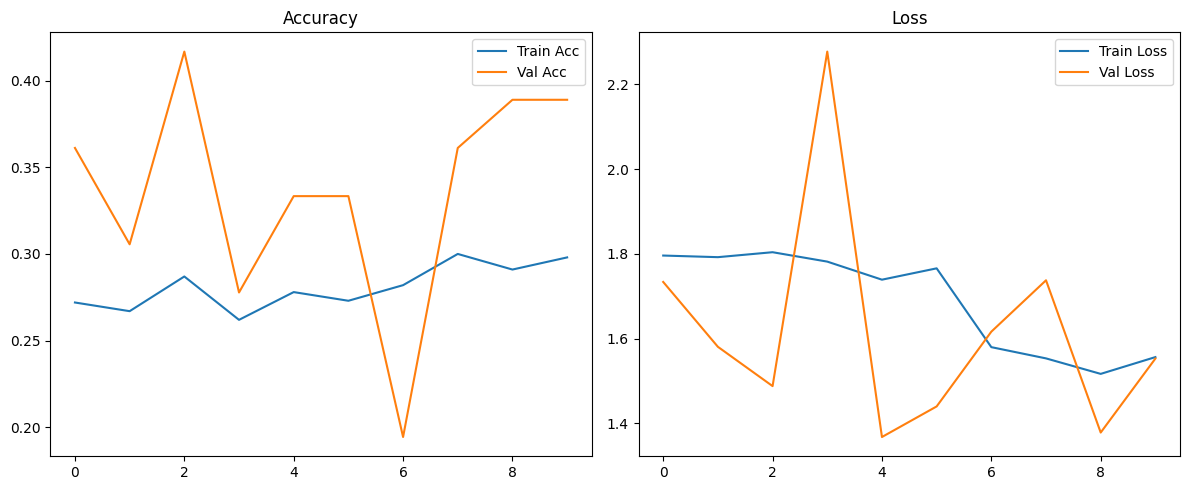

In [4]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# --- Plot History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

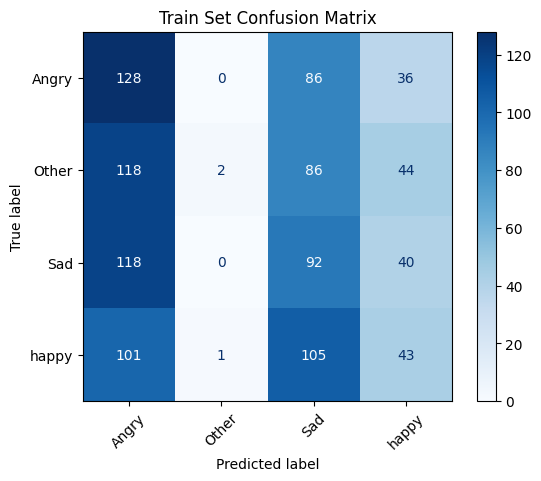

Classification Report - Train Set
              precision    recall  f1-score   support

       Angry     0.2753    0.5120    0.3580       250
       Other     0.6667    0.0080    0.0158       250
         Sad     0.2493    0.3680    0.2973       250
       happy     0.2638    0.1720    0.2082       250

    accuracy                         0.2650      1000
   macro avg     0.3638    0.2650    0.2198      1000
weighted avg     0.3638    0.2650    0.2198      1000



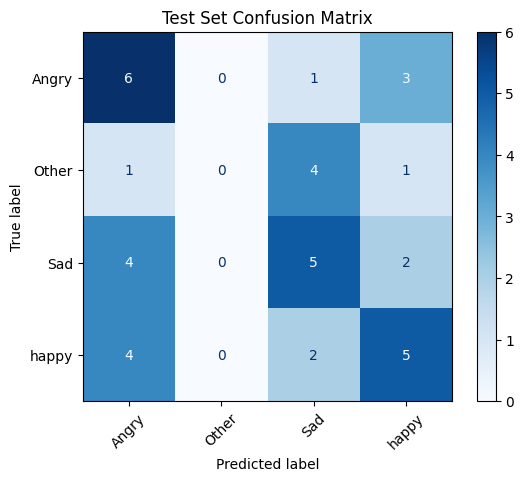

Classification Report - Test Set
              precision    recall  f1-score   support

       Angry     0.4000    0.6000    0.4800        10
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4167    0.4545    0.4348        11
       happy     0.4545    0.4545    0.4545        11

    accuracy                         0.4211        38
   macro avg     0.3178    0.3773    0.3423        38
weighted avg     0.3575    0.4211    0.3838        38



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# --- Confusion Matrix & Report ---
def evaluate_generator(gen, title):
    gen.reset()
    y_pred_probs = model.predict(gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = gen.classes
    class_names = list(gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{title} Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

    print(f"Classification Report - {title}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

evaluate_generator(train_generator, "Train Set")
evaluate_generator(test_generator, "Test Set")